In [1]:
!pip install pandas
!pip install matplotlib seaborn xgboost
!pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import machine learning model for weather prediction
import xgboost as xgb

from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

In [3]:
# loading london weather data
df = pd.read_csv("london_weather.csv")

In [4]:
# convert 'date' column to string
df["date"] = df["date"].astype(str)

# create 'formattedDate' column by parsing the 'date' column
df["formattedDate"] = pd.to_datetime(df["date"], format='%Y%m%d')

# set the 'formattedDate' column as the index
df.set_index("formattedDate", inplace=True)

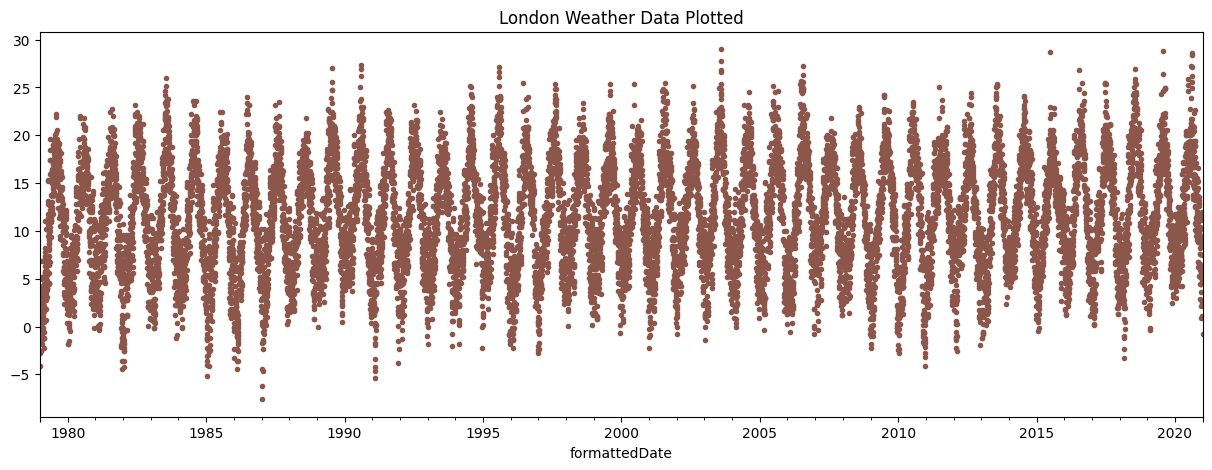

In [5]:
df['mean_temp'].plot(style='.', figsize=(15,5), color=color_pal[5], title= 'London Weather Data Plotted')
plt.show()

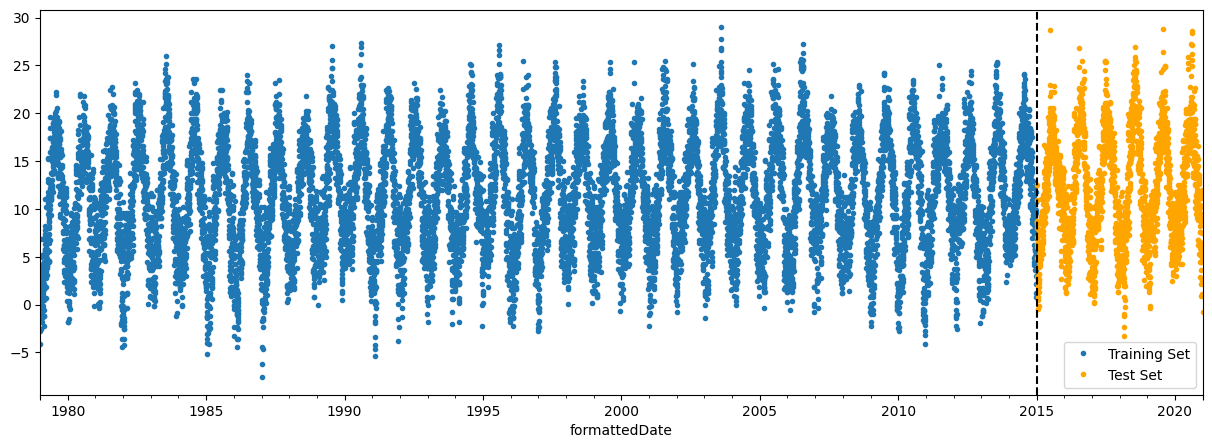

In [6]:
# Train / Test Split
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

# plotting the training and test sets
fig, ax = plt.subplots(figsize=(15, 5))
train['mean_temp'].plot(ax=ax, style='.', label='Training Set')
test['mean_temp'].plot(ax=ax, style='.', label='Test Set', color='orange')

# add vertical line to the axes at the 2015-01-01 date
ax.axvline(x=pd.to_datetime('2015-01-01'), color='black', linestyle='--')

ax.legend()
plt.show()

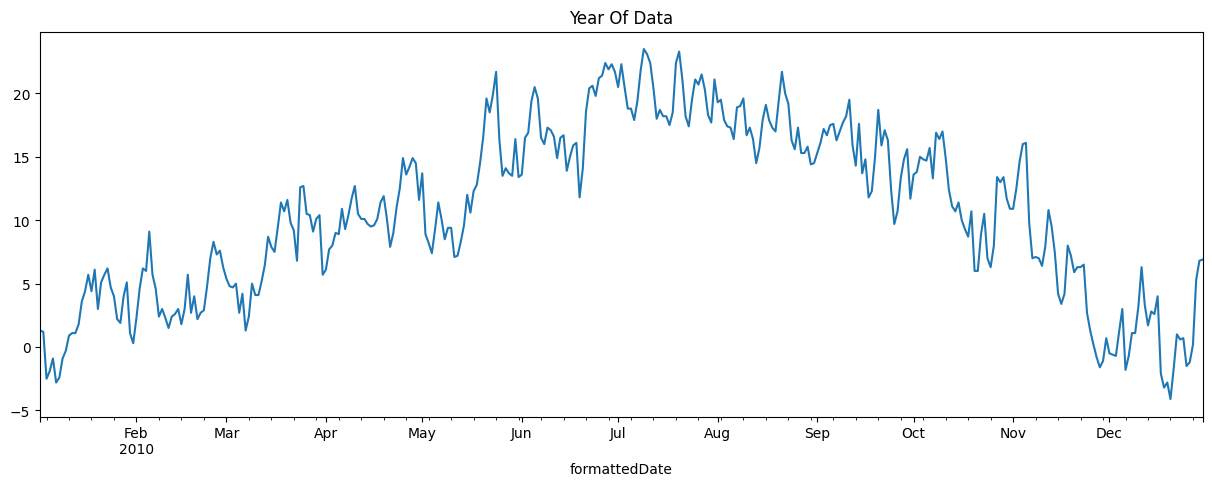

In [7]:
df['mean_temp'].loc[(df.index > '2010-01-01') & (df.index < '2010-12-31')] \
    .plot(figsize=(15, 5), title='Year Of Data')
plt.show()

In [8]:
# Feature Creation
def create_features(df):
    """
    Create time series features based on the DataFrame index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    return df

df = create_features(df)

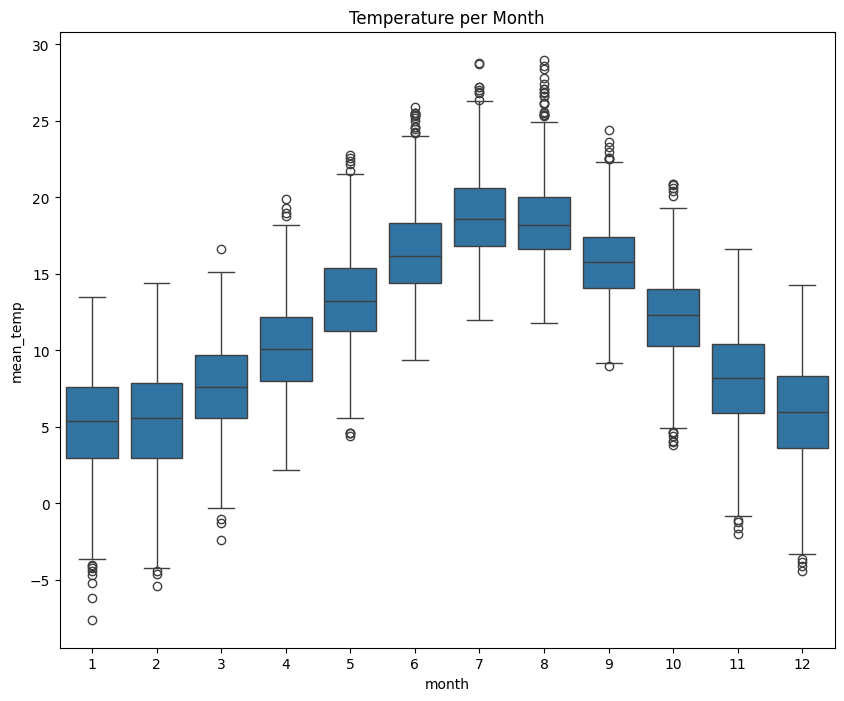

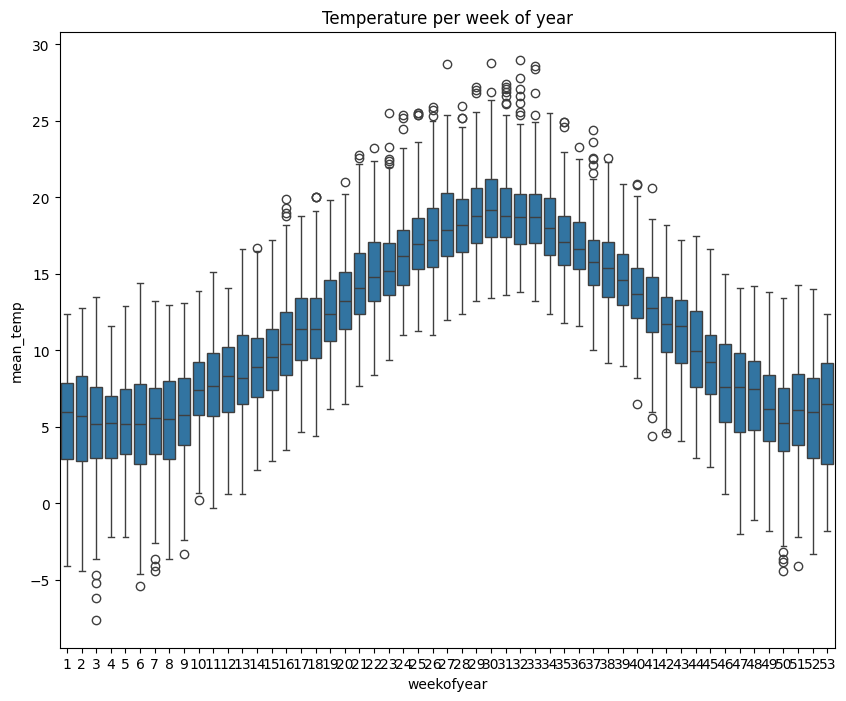

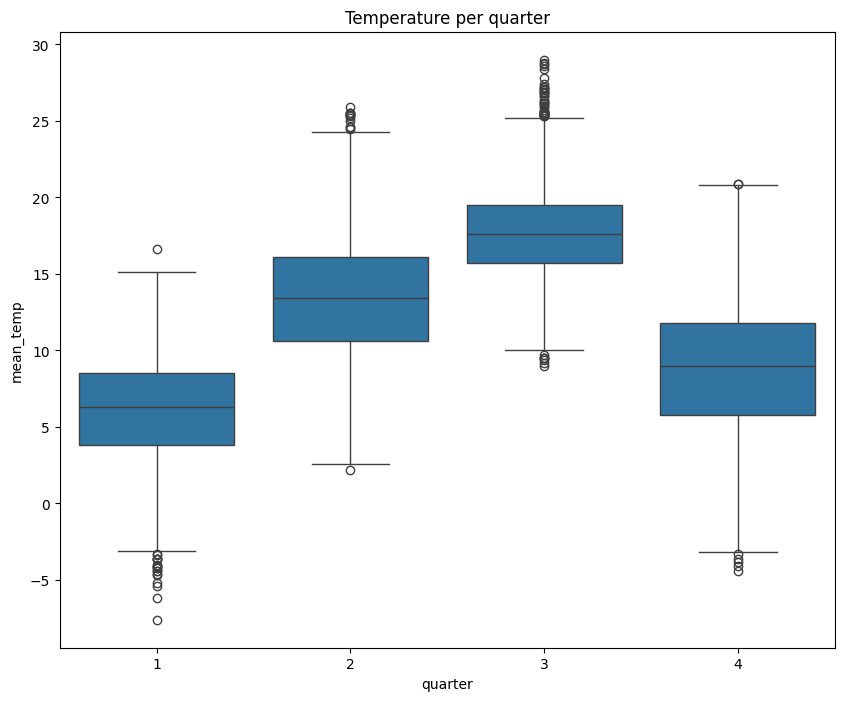

In [9]:
# Visualize our Feature/Target Relationship

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='mean_temp')
ax.set_title('Temperature per Month')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='weekofyear', y='mean_temp')
ax.set_title('Temperature per week of year')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='quarter', y='mean_temp')
ax.set_title('Temperature per quarter')
plt.show()

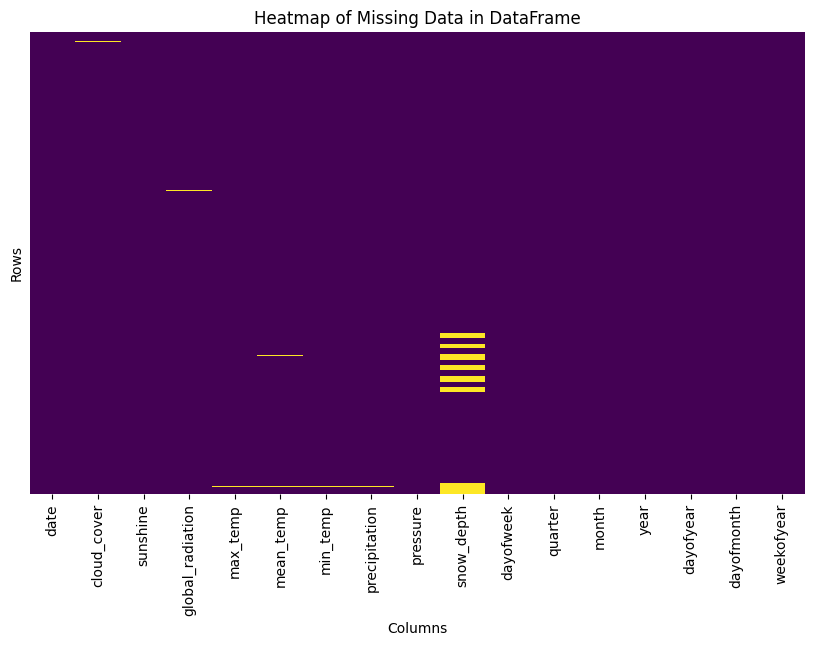

In [12]:
# created heatmap to visulaize the pattern of missing data
missing_data = df.isna()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(missing_data, cbar=False, yticklabels=False, cmap='viridis')

# Add title and labels as needed
plt.title('Heatmap of Missing Data in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Rows')

# Display the plot
plt.show()

In [ ]:
# the plot above shows that only a small proportion of rows are effected when NaN values are removed

In [13]:
# Create Our Model

train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'weekofyear' ,'dayofweek', 'dayofmonth' , 'quarter', 'month', 'year']
TARGET = 'mean_temp'

# Drop rows with NaN values in the features or the target
train = train.dropna(subset=FEATURES + [TARGET])
test = test.dropna(subset=FEATURES + [TARGET])

# Prepare the training and test datasets
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [14]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:12.14924	validation_1-rmse:12.94810
[100]	validation_0-rmse:5.25820	validation_1-rmse:5.92603
[200]	validation_0-rmse:3.29998	validation_1-rmse:3.71613
[300]	validation_0-rmse:2.89962	validation_1-rmse:3.08991
[400]	validation_0-rmse:2.81815	validation_1-rmse:2.92462
[500]	validation_0-rmse:2.78776	validation_1-rmse:2.89209
[600]	validation_0-rmse:2.76879	validation_1-rmse:2.88362
[700]	validation_0-rmse:2.75476	validation_1-rmse:2.88287
[702]	validation_0-rmse:2.75456	validation_1-rmse:2.88343


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

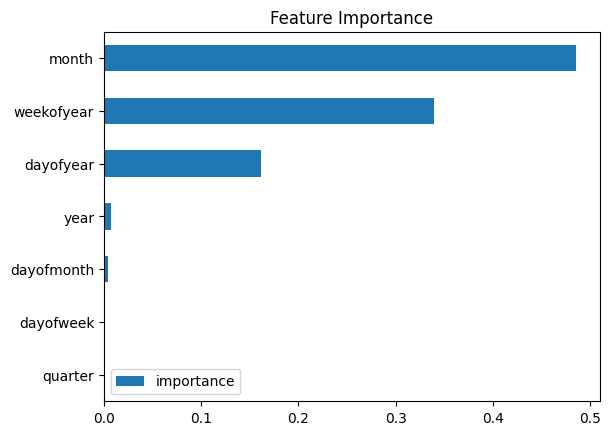

In [16]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [20]:
# Forecast on test set with trained model

test['prediction'] = reg.predict(X_test)

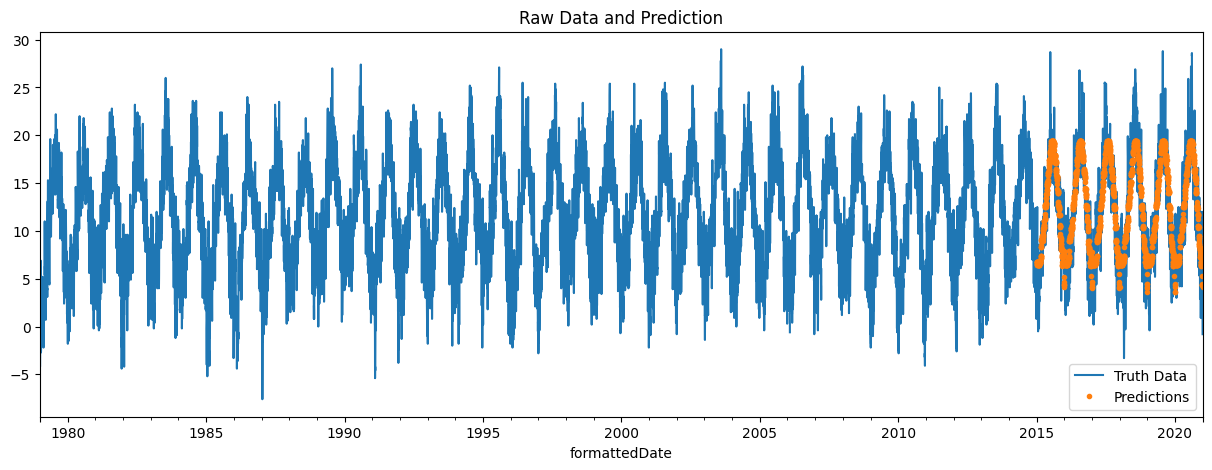

In [21]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['mean_temp']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

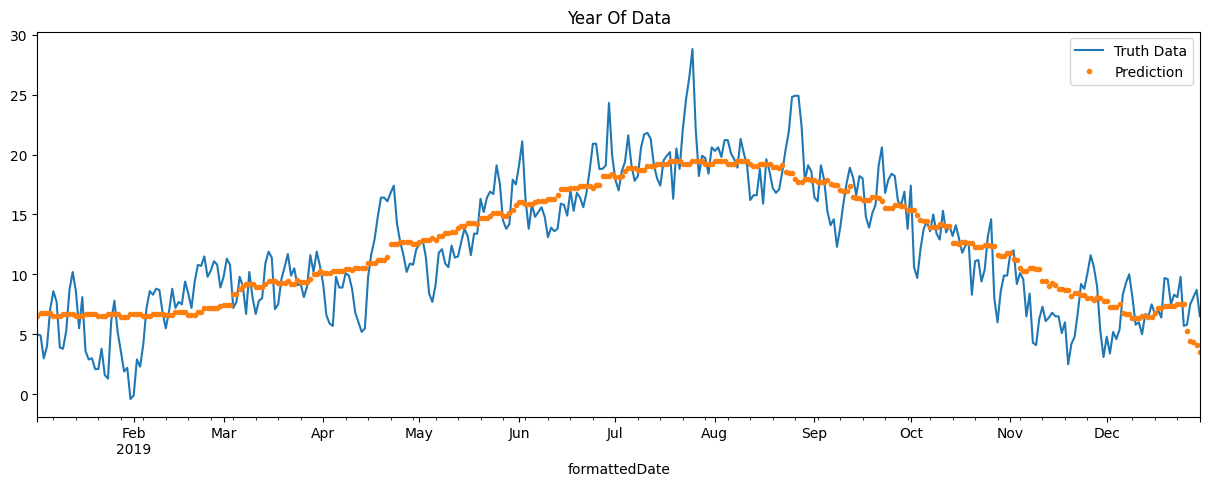

In [30]:
# see the model's prediction for a chosen year
ax = df['mean_temp'].loc[(df.index > '2019-01-01') & (df.index < '2019-12-31')] \
    .plot(figsize=(15, 5), title='Year Of Data')

df.loc[(df.index > '2019-01-01') & (df.index < '2019-12-31')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [25]:
# calculate the score of the model
score = np.sqrt(mean_squared_error(test['mean_temp'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 2.88


In [28]:
# Calculate Error
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-07-01    10.543493
2018-02-28    10.485313
2018-03-01     9.814509
2018-03-18     9.759148
2020-08-12     9.586765
2015-12-27     9.558106
2019-07-25     9.365998
2020-08-11     9.176852
2018-03-17     8.959148
2018-04-19     8.702682
Name: error, dtype: float64